## Fetch Traffic Data

Download raw traffic data from https://roadtraffic.dft.gov.uk/downloads/

In [103]:
import pandas as pd
import zipfile 
import io
import requests 
import os 

def wrangle_dft_traffic_data(road_name="A406", url="https://storage.googleapis.com/dft-statistics/road-traffic/downloads/data-gov-uk/dft_traffic_counts_raw_counts.zip"):
    """
    Download and preprocess DfT traffic counts CSV, filter for a specific road.

    Args:
        road_name (str): Name of the road to filter (e.g., "A406").
        url (str): URL of the DfT traffic counts CSV.

    Returns:
        pd.DataFrame: Clean DataFrame with datetime index and traffic counts.
    """
    response = requests.get(url)

    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
        files = [f for f in zip_file.namelist() if not f.startswith('__MACOSX/')]
        if len(files) > 1:
            raise ValueError("Multiple files found in ZIP file")
        file = files[0]
        with zip_file.open(file) as f:
            df = pd.read_csv(f,low_memory=False)
        
    # Filter for the road
    road_df = df[df["road_name"] == road_name].copy()
    if road_df.empty:
        raise ValueError(f"No data found for road '{road_name}'")

    # create datetime column from date and time columns
    road_df['datetime'] = pd.to_datetime(road_df['count_date'] + ' ' + road_df['hour'].astype(str) + ':00:00')
    road_df.set_index('datetime', inplace=True)
    road_df.sort_index(inplace=True)
    
    # drop low cardinality columns
    cols_to_drop = ['count_date', 
                    'hour', 
                    'road_name', 
                    'road_type',
                    'road_category',
                    'region_name',
                    'region_ons_code',
                    'region_id',
                    'road_name',
                    'road_type',
                    'road_category']
    
    road_df.drop(columns=cols_to_drop, inplace=True)

    # nromalize column 
    # Only normalize numeric columns
    numeric_cols = road_df.select_dtypes('number').columns
    print(f"Numeric columns to normalize: {list(numeric_cols)}")
    if not numeric_cols.empty:
        road_df[numeric_cols] = road_df[numeric_cols] / road_df[numeric_cols].max()

   
    
    print(f"RL-ready traffic data prepared for road '{road_name}'. Total rows: {len(road_df)}")

    # save to csv
    os.makedirs("../data/processed", exist_ok=True)
    road_df.to_csv(f"../data/processed/dft_traffic_{road_name}.csv",date_format='%Y-%m-%d %H:%M:%S')
    print(f"Data saved to ../data/processed/dft_traffic_{road_name}.csv")
    return road_df


road_name="A406"
road_df = wrangle_dft_traffic_data(road_name)


Numeric columns to normalize: ['count_point_id', 'year', 'local_authority_id', 'easting', 'northing', 'latitude', 'longitude', 'link_length_km', 'link_length_miles', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle', 'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle', 'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'all_HGVs', 'all_motor_vehicles']
RL-ready traffic data prepared for road 'A406'. Total rows: 11016
Data saved to ../data/processed/dft_traffic_A406.csv


In [107]:
# read the processed data
road_df = pd.read_csv(f"../data/processed/dft_traffic_{road_name}.csv",parse_dates=["datetime"],   # convert column to datetime
    index_col="datetime")        # set it as the index)
# road_df.set_index('datetime', inplace=True)

In [112]:
road_df.shape

(11016, 27)

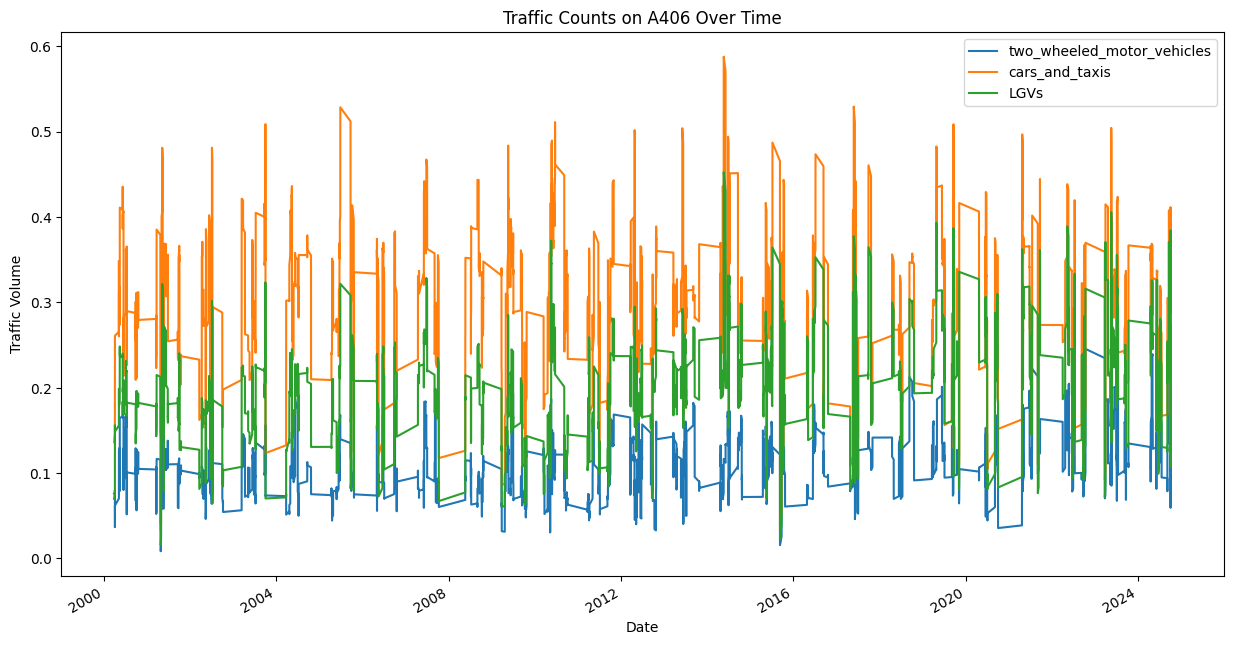

In [111]:
import matplotlib.pyplot as plt

columns_of_interest = [ "two_wheeled_motor_vehicles", "cars_and_taxis", "LGVs"]
(road_df[columns_of_interest]
 .rolling(24)
 .mean()
.plot(
    figsize=(15,8), 
    title="Traffic Counts on A406 Over Time",
    ylabel="Traffic Volume",
    xlabel="Date"
)
);